In [6]:
library(ggplot2)
library(reshape2)
library(cowplot)
theme_set(theme_cowplot())


# Input

In [7]:
asv_tab <- read.table("data/asv_table.tsv", sep="\t", comment.char="", skip=1, header=1, row.names=1)
md <- read.table("data/METADATA.txt", sep="\t", header=1, row.names=1)
taxonomy <- read.table("data/taxonomy.tsv", sep="\t", header=1, row.names=1)
shannon <- read.table("data/shannon.tsv", sep="\t", row.names=1, header=1)
pd <- read.table("data/pd.tsv", sep="\t", row.names=1, header=1)
oasvs <- read.table("data/observed_asvs.tsv", sep="\t", row.names=1, header=1)
rownames(md) <- gsub("-",".",rownames(md))
rownames(shannon) <- gsub("-",".",rownames(shannon))
rownames(pd) <- gsub("-",".",rownames(pd))
rownames(oasvs) <- gsub("-",".",rownames(oasvs))

# Data Formatting

In [8]:
asv_tab <- scale(asv_tab, center=FALSE, scale=colSums(asv_tab))
m_asv_tab <- melt(asv_tab)
colnames(m_asv_tab) <- c("asv_id", "sample_id", "rel_abund")
m_asv_tab$phase <- md[as.vector(m_asv_tab$sample_id),'phase']
m_asv_tab$time <- md[as.vector(m_asv_tab$sample_id),'timePoint']
m_asv_tab$type <- md[as.vector(m_asv_tab$sample_id),'sampleType']
m_asv_tab$full_taxonomy <- taxonomy[as.vector(m_asv_tab$asv_id), 'Taxon']
alpha <- melt(as.matrix(data.frame(pd, shannon, oasvs)))
colnames(alpha) <- c("sample_id", "measure", "value")
alpha$time <- md[as.vector(alpha$sample_id),'timePoint']
alpha$phase <- md[as.vector(alpha$sample_id),'phase']
alpha$type <- md[as.vector(alpha$sample_id),'sampleType']
alpha$subject <- md[as.vector(alpha$sample_id), 'subject']
x <- as.vector(alpha$time)
x[x == "B"] <- "-7"
alpha$time <- as.numeric(x)
#md$timePoint <- factor(md$timePoint, levels=c("B", 0, 7, 14, 21, 28, 35))
alpha$WBC <- md[as.vector(alpha$sample_id), 'WBC']
alpha$Rel_WBC <- md[as.vector(alpha$sample_id), 'Rel_WBC']
alpha$BI <- md[as.vector(alpha$sample_id), 'Bleeding_Index']
alpha$BS <- md[as.vector(alpha$sample_id), 'Bleeding_Score']
alpha$MPD <- md[as.vector(alpha$sample_id), 'MPD']
levels(alpha$type) <- c("Saliva", "Subgingival", "Supragingival", "Tongue")
levels(alpha$phase) <- c("Induction", "Pre-induction", "Restoration")
alpha$phase <- factor(alpha$phase, c("Pre-induction", "Induction", "Restoration"))
head(alpha)

,sample_id,measure,value,time,phase,type,subject,WBC,Rel_WBC,BI,BS,MPD
,<fct>,<fct>,<dbl>,<dbl>,<fct>,<fct>,<fct>,<int>,<dbl>,<dbl>,<dbl>,<dbl>
1,P11.Sal.0,faith_pd,11.67312,0,Induction,Saliva,P11,4560000,1.0000000,0.04,18.45,1.98
2,P11.Sal.14,faith_pd,19.81678,14,Induction,Saliva,P11,2947200,0.6463158,0.13,33.29,1.98
3,P11.Sal.21,faith_pd,18.56768,21,Induction,Saliva,P11,2200000,0.4824561,0.96,58.33,1.99
4,P11.Sal.28,faith_pd,16.72866,28,Restoration,Saliva,P11,3043200,0.6673684,1.46,52.98,2.42
5,P11.Sal.35,faith_pd,11.72115,35,Restoration,Saliva,P11,2526400,0.5540351,0.04,11.31,1.71
6,P11.Sal.7,faith_pd,11.38721,7,Induction,Saliva,P11,7588800,1.6642105,0.00,2.90,1.29


# Plots

`geom_smooth()` using formula 'y ~ x'



png 
  2

`geom_smooth()` using formula 'y ~ x'



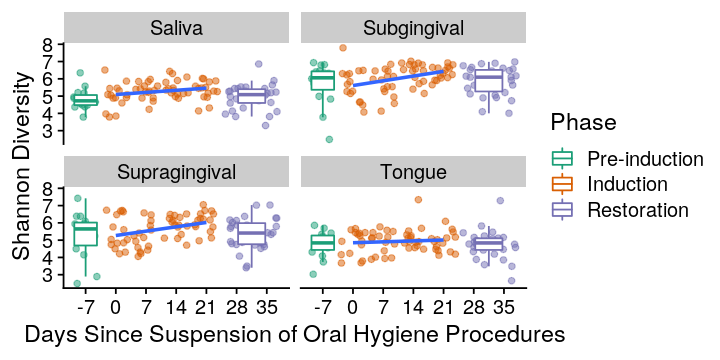

In [13]:
# Alpha Diversity
options(repr.plot.width=6, repr.plot.height=3)
pdf("Figure1.pdf", height=4, width=7)

p<-ggplot(subset(alpha, measure=='shannon'), aes(y=value, x=time)) + 
   facet_wrap(vars(type), ncol=2) +
   geom_point(aes(colour=phase), alpha=0.5, position='jitter') + 
   geom_boxplot(data=subset(subset(alpha,measure=='shannon'),phase%in%c('Pre-induction', 'Restoration')), aes(group=phase, colour=phase), outlier.shape=NA) +
   geom_smooth(data=subset(subset(alpha, measure=='shannon'),phase%in%c('Induction')), 
               method='glm', se=FALSE) +
   scale_colour_brewer(palette = "Dark2", name="Phase") +
   xlab("Days Since Suspension of Oral Hygiene Procedures") + ylab("Shannon Diversity") +
   scale_x_continuous(breaks=unique(alpha$time))
p
dev.off()
p

`geom_smooth()` using formula 'y ~ x'



png 
  2

`geom_smooth()` using formula 'y ~ x'



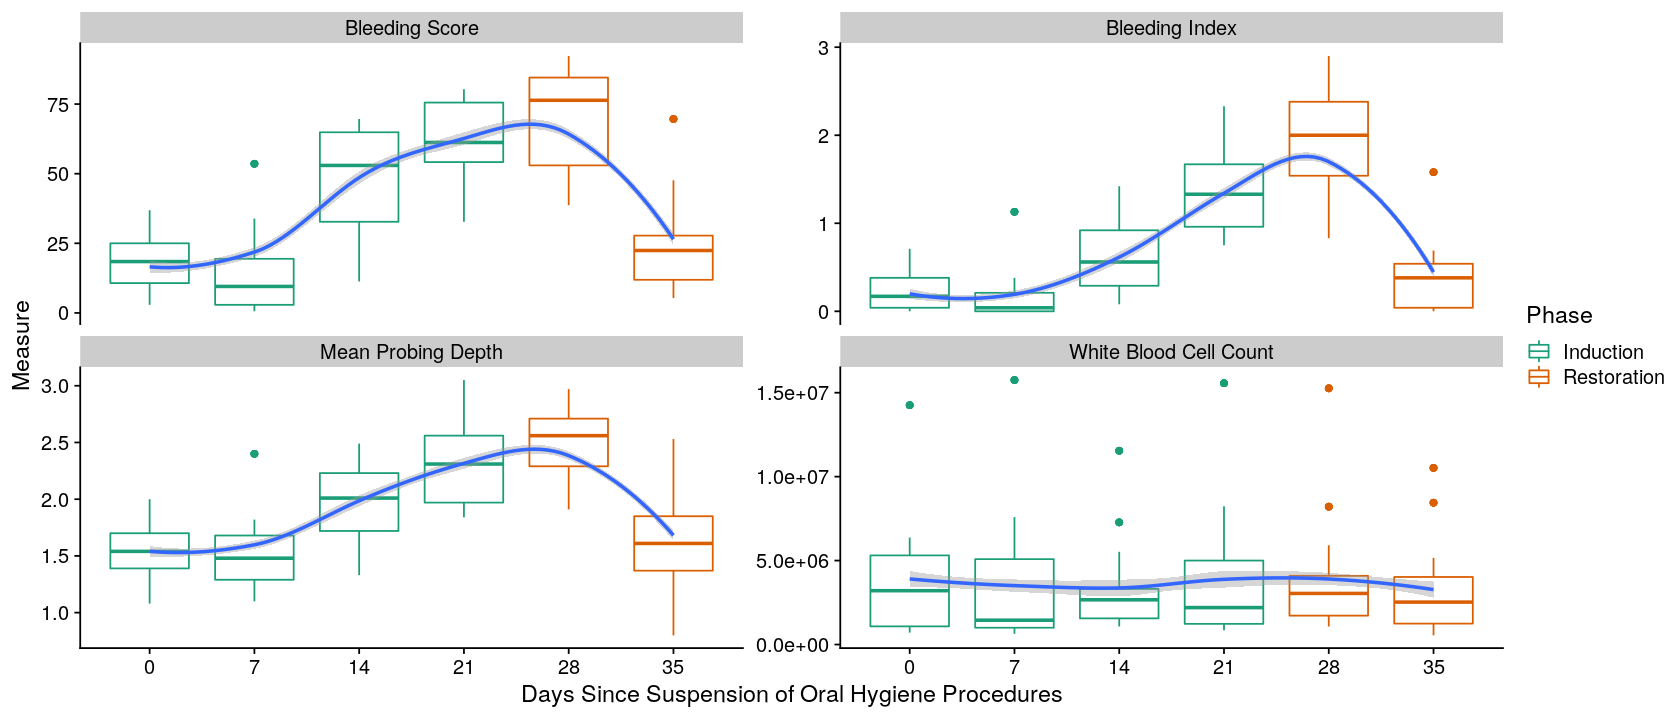

In [14]:
# Alpha Diversity
options(repr.plot.width=14, repr.plot.height=6)
pdf("GlogauerMetadata.pdf", height=4, width=7)
gmd <- subset(alpha, type="Saliva")
gmd <- subset(gmd, time %in% c(0,7,14,21,28,35))

gmd<-melt(gmd, id.vars=c("sample_id", "phase","time"), measure.vars=c("BS","BI","MPD","WBC"))
levels(gmd$time) <- c(0,7,14,21,28,35)
p<-ggplot(gmd, aes(y=value, x=time)) + 
   facet_wrap(.~variable, scale="free_y", ncol=2, labeller = as_labeller(c(BS="Bleeding Score", BI="Bleeding Index", WBC="White Blood Cell Count", MPD="Mean Probing Depth")))+
   geom_boxplot(aes(colour=phase, group=time), alpha=0.5) + 
geom_smooth(method="loess")+
   scale_colour_brewer(palette = "Dark2", name="Phase") +
   xlab("Days Since Suspension of Oral Hygiene Procedures") + ylab("Measure") +
   scale_x_continuous(breaks=unique(gmd$time))
p
dev.off()
p

In [11]:
salshan<-subset(subset(subset(alpha, measure=='shannon'), type=='Saliva'), phase%in%c("Pre-Induction","Induction"))
subgshan<-subset(subset(subset(alpha, measure=='shannon'), type=='Subgingival'), phase%in%c("Pre-Induction","Induction"))
supgshan<-subset(subset(subset(alpha, measure=='shannon'), type=='Supragingival'), phase%in%c("Pre-Induction","Induction"))
tongueshan<-subset(subset(subset(alpha, measure=='shannon'), type=='Tongue'), phase%in%c("Pre-Induction","Induction"))
salshan$time<-as.numeric(salshan$time)
subgshan$time<-as.numeric(subgshan$time)
supgshan$time<-as.numeric(supgshan$time)
tongueshan$time<-as.numeric(tongueshan$time)
glm_slopes <- data.frame()
for (subj in unique(alpha$subject)) {
    glm_slopes["Saliva", subj] <- glm(value~time, family="gaussian", salshan, subset=subject==subj)$coef["time"]
    glm_slopes["Subgingival", subj] <- glm(value~time, family="gaussian", subgshan, subset=subject==subj)$coef["time"]
    glm_slopes["Supragingival", subj] <- glm(value~time, family="gaussian", supgshan, subset=subject==subj)$coef["time"]
    glm_slopes["Tongue", subj] <- glm(value~time, family="gaussian", tongueshan, subset=subject==subj)$coef["time"]

    }

rowMeans(glm_slopes)
glm_slopes

Saliva   Subgingival Supragingival        Tongue 
  0.017530530   0.039189383   0.035945277   0.007523255

,P11,P12,P13,P14,P15,P16,P17,P18,P19,P20,P21,P22,P23,P24,P25
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
Saliva,0.009627181,0.037076852,0.0025055667,0.03371331,0.01479823,0.0009123345,0.007721931,0.015710795,0.007722945,4.053013e-05,0.06946273,0.00914509,0.03031176,0.04410971,-0.019901002
Subgingival,0.084214260,0.005976417,0.0003909985,0.06456202,0.11479716,-0.0392931536,0.083588353,0.015660803,0.006511709,1.327673e-02,0.04654999,0.08372492,0.01558398,0.08384640,0.008450147
Supragingival,0.037647767,-0.033718194,0.0068517328,0.06636643,0.02695433,0.0461922742,0.067766457,-0.008207572,0.008998008,-6.418168e-03,0.10745442,0.10668486,0.03140701,0.07654077,0.004659029
Tongue,0.025249400,0.049681512,0.0003425304,0.07123523,0.02166167,0.0127727862,-0.006412973,-0.019024703,-0.026091487,2.518251e-02,0.03120616,0.00132665,0.01618726,-0.02996947,-0.060498247


In [70]:
?data.frame

In [5]:
sessionInfo()

R version 3.4.3 (2017-11-30)
Platform: x86_64-pc-linux-gnu (64-bit)
Running under: Ubuntu 18.04.1 LTS

Matrix products: default
BLAS: /usr/lib/x86_64-linux-gnu/blas/libblas.so.3.7.1
LAPACK: /usr/lib/x86_64-linux-gnu/lapack/liblapack.so.3.7.1

locale:
 [1] LC_CTYPE=en_CA.UTF-8       LC_NUMERIC=C              
 [3] LC_TIME=en_CA.UTF-8        LC_COLLATE=en_CA.UTF-8    
 [5] LC_MONETARY=en_CA.UTF-8    LC_MESSAGES=en_CA.UTF-8   
 [7] LC_PAPER=en_CA.UTF-8       LC_NAME=C                 
 [9] LC_ADDRESS=C               LC_TELEPHONE=C            
[11] LC_MEASUREMENT=en_CA.UTF-8 LC_IDENTIFICATION=C       

attached base packages:
[1] stats     graphics  grDevices utils     datasets  methods   base     

other attached packages:
[1] cowplot_0.9.3  reshape2_1.4.3 ggplot2_3.1.0 

loaded via a namespace (and not attached):
 [1] Rcpp_0.12.19         RColorBrewer_1.1-2   pillar_1.3.0        
 [4] compiler_3.4.3       plyr_1.8.4           bindr_0.1.1         
 [7] base64enc_0.1-3      tools_3.4.3    

In [17]:
?subset